In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

# Ejercicio de clasificación - Regresión logística
**Facundo A. Lucianna - Inteligencia Artificial - CEIA - FIUBA**

Vamos a aprender a aplicar el modelo de **regresión logística** mediante *scikit-learn*. Como vimos, este modelo es uno de los algoritmos más sencillos y eficientes para tareas de clasificación binaria. A pesar de su nombre, no se utiliza para problemas de regresión, sino que estima la probabilidad de que una observación pertenezca a una clase particular. Lo hace ajustando una función sigmoide sobre una combinación lineal de los atributos, lo que permite clasificar observaciones en una de dos clases posibles.

Para aplicar este modelo, vamos a usar el famosísimo [dataset Iris](https://scikit-learn.org/stable/datasets/toy_dataset.html#iris-dataset), el cual, tal como vimos en el Módulo 4, contiene datos sobre tres especies de flores (*Setosa*, *Versicolor* y *Virginica*), con cuatro características de cada flor: **largo y ancho del sépalo** y **largo y ancho del pétalo**. 

Vamos a obtener los datos de este dataset directamente desde *scikit-learn* y convertirlos en un DataFrame de Pandas:

In [2]:
from sklearn import datasets 
iris = datasets.load_iris()

df_iris = pd.DataFrame(iris.data, columns=iris.feature_names)

# Guardamos el label
label_dict = {
    0: "setosa",
    1: "versicolor",
    2: "virginica"
}
df_iris["label"] = iris.target
df_iris["label"] = df_iris["label"].apply(lambda x: label_dict[x])

In [3]:
df_iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


Veamos una descripción del conjunto de datos:

In [4]:
df_iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   label              150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [5]:
df_iris.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


Obtengamos gráficamente las relaciones por pares del conjunto de datos y la distribución de los atributos, coloreando las observaciones por clase. Para ello, usamos Seaborn:

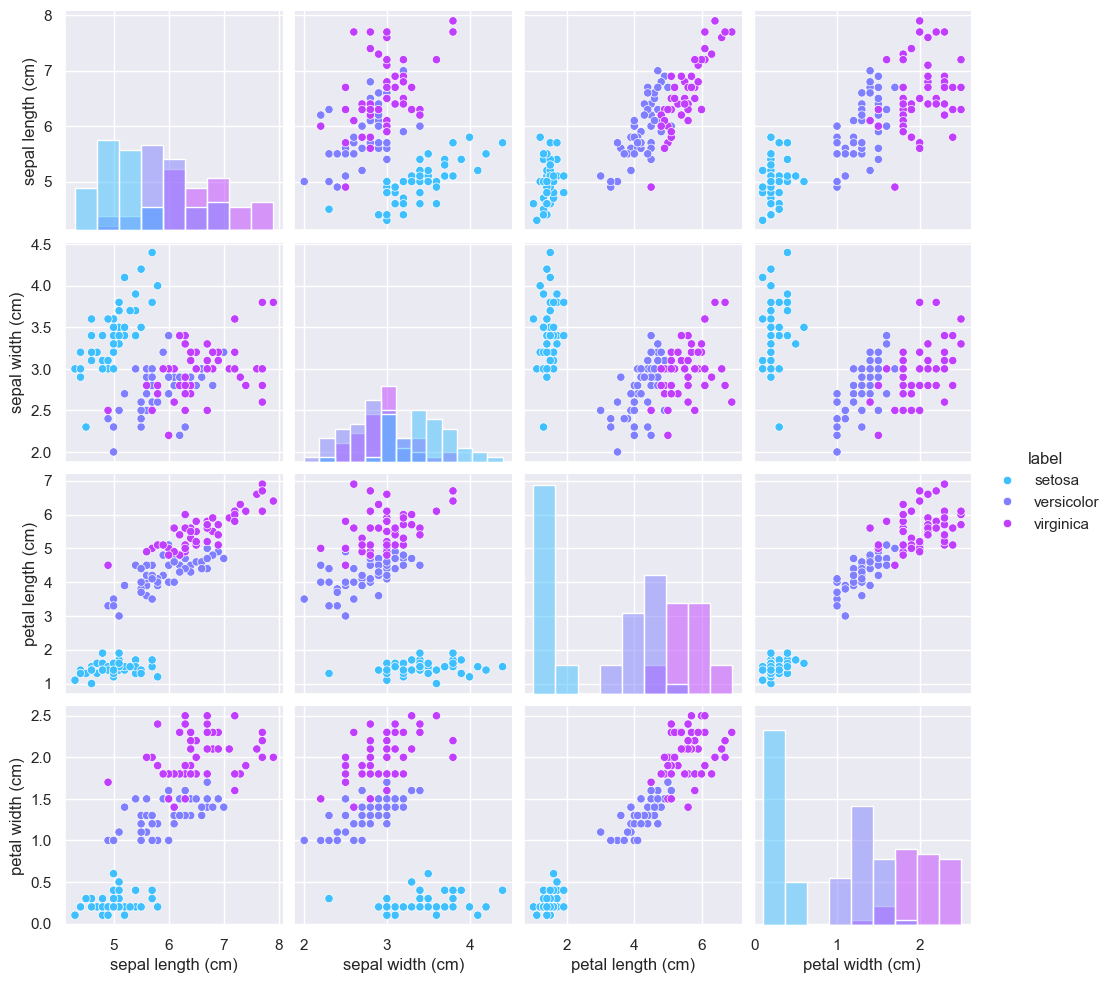

In [6]:
sns.pairplot(data=df_iris, diag_kind="hist", hue="label", palette="cool");

Estos gráficos nos muestran que las plantas *setosa* presentan una gran separación cuando consideramos atributos como el largo del pétalo. También, al combinar dos atributos cualesquiera, esta especie se separa con claridad de las otras dos. Por otro lado, entre *virginica* y *versicolor*, se observa que las distribuciones del pétalo (en alguna de sus dimensiones) muestran cierta separación, aunque con algo de solapamiento. Sin embargo, cuando se combinan dos atributos, esta separación se hace más evidente. Podemos conjeturar, que probablemente una combinación de tres o más atributos generará una mejor separación entre las clases.

## Regresión logística binaria

Claramente, estos gráficos nos indican que, si aplicamos algún modelo de clasificación, obtendremos buenos resultados. Por lo tanto, vamos a utilizar regresión logística para clasificar. Dado que este modelo, por defecto, tiene una salida binaria, vamos a reformular el problema para clasificar si una planta es `virginica` o `no virginica`.

Para ello, creamos un nuevo label que represente este estado binario:

In [7]:
df_iris["label_binary"] = 1
df_iris.loc[df_iris["label"] != "virginica", "label_binary"] = 0

# Veamos una muestra aleatoria del dataset
df_iris.sample(frac=1.0).head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label,label_binary
12,4.8,3.0,1.4,0.1,setosa,0
96,5.7,2.9,4.2,1.3,versicolor,0
66,5.6,3.0,4.5,1.5,versicolor,0
76,6.8,2.8,4.8,1.4,versicolor,0
10,5.4,3.7,1.5,0.2,setosa,0


Ahora, separemos el dataset en entrenamiento y evaluación:

In [8]:
from sklearn.model_selection import train_test_split

# Armamos un DataFrame con los features
X = df_iris.drop(columns=["label", "label_binary"])
# Y con la variable dependiente (target)
y = df_iris["label_binary"]

In [9]:
print(f"X es de tipo: {type(X)}")
print(f"El shape es de 2D: {X.shape}")

X es de tipo: <class 'pandas.core.frame.DataFrame'>
El shape es de 2D: (150, 4)


In [10]:
print(f"El label es de tipo: {type(y)}")
print(f"El shape es de 1D: {y.shape}")

El label es de tipo: <class 'pandas.core.series.Series'>
El shape es de 1D: (150,)


In [11]:
# Proporción de clases
y.value_counts()

label_binary
0    100
1     50
Name: count, dtype: int64

El valor `1` corresponde a las observaciones que son `virginica`, mientras que el `0` representa a las otras dos especies. Tenemos una relación aproximada de 2 a 1 entre clases negativas (`no virginica`) y positivas (`virginica`). Esta desproporción no requiere, por el momento, aplicar técnicas de balanceo.

Separamos entonces los datos:

In [12]:
# Separando nuestro dataset en entrenamiento y testeo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

print("Observaciones de X_train:",X_train.shape[0])
print("Observaciones de y_train:",y_train.size)
print("Observaciones de X_test:",len(X_test))
print("Observaciones de y_test:",len(y_test))

Observaciones de X_train: 105
Observaciones de y_train: 105
Observaciones de X_test: 45
Observaciones de y_test: 45


Para la regresión logística es mejor tener los atributos normalizados:

In [13]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

# Entrenamos el escalador solo con el set de entrenamiento
X_train_scaled = sc.fit_transform(X_train)
# Y transformamos el set de testeo
X_test_scaled = sc.transform(X_test)

> ⚠️ **Nota**: En esta sección hicimos el escalado de forma manual para explicar cuándo aplicar `fit_transform()` y cuándo usar `transform()`. En los siguientes pasos, vamos a utilizar `Pipelines`, tal como hicimos en los casos de regresión, para automatizar y simplificar el flujo de trabajo.

---
### Primer modelo de regresión logística

Podemos construir un primer modelo utilizando un solo atributo para observar cómo se comporta la probabilidad de clasificación. De los gráficos de distribución vimos que el **ancho del pétalo** es una variable que parece separar bastante bien a la clase `virginica` del resto.

In [14]:
X_train_one = X_train[["petal width (cm)"]]
X_test_one = X_test[["petal width (cm)"]]

Veamos cómo se distribuyen los datos respecto a la probabilidad de ser o no virginica, dado el ancho del pétalo:

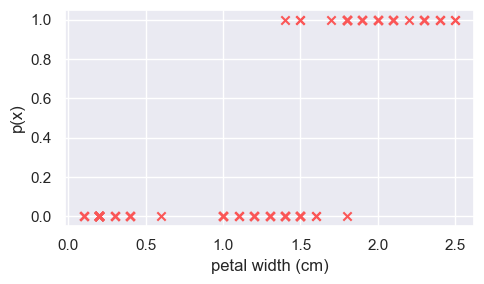

In [15]:
plt.figure(figsize=(5, 3))
plt.scatter(X_train_one, y_train, marker="x", color="#fb5757")
plt.xlabel("petal width (cm)")
plt.ylabel("p(x)")
plt.tight_layout()
plt.show()

Observamos que las muestras con pétalos más anchos tienen una probabilidad de 1 de ser virginica (dado que son observaciones que conocemos que son), tal como anticipamos en los gráficos de distribución.

Ahora, con los datos de entrenamiento, entrenamos el modelo de regresión logística provisto por  [sckit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

In [16]:
from sklearn.linear_model import LogisticRegression

Creamos el pipeline:

In [17]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Preprocesamiento para las columnas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ["petal width (cm)"]) # Escalamos la variable numérica
    ]
)

# Pipeline: preprocesamiento + modelo
log_1_attr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LogisticRegression(random_state=0))
])

log_1_attr

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['petal width (cm)'])])),
                ('regressor', LogisticRegression(random_state=0))])

Entrenamos el modelo:

In [18]:
log_1_attr.fit(X_train_one, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['petal width (cm)'])])),
                ('regressor', LogisticRegression(random_state=0))])

Visualizamos ahora la regresión:

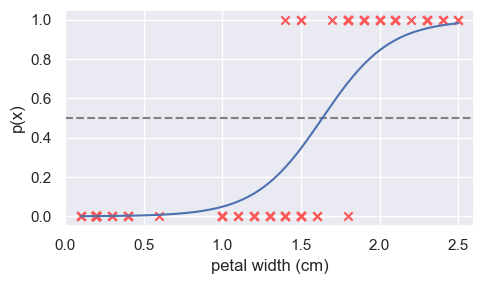

In [19]:
#Obtengamos la función logistica
xx = np.linspace(np.min(X_train_one), np.max(X_train_one), 1000)
xx = pd.DataFrame({"petal width (cm)": xx})
# Usando el método que nos da las probabilidades
yy = log_1_attr.predict_proba(xx)

plt.figure(figsize=(5, 3))
plt.plot([-1000, 100000], [0.5, 0.5], linestyle="--", color="gray")
plt.scatter(X_train_one, y_train, marker="x", color="#fb5757")
plt.plot(xx, yy[:, 1])
plt.xlabel("petal width (cm)")
plt.ylabel("p(x)")
plt.xlim([np.min(X_train_one) - 0.1, np.max(X_train_one) + 0.1])
plt.tight_layout()
plt.show()

En este gráfico vemos cómo se modela la probabilidad: 
- Cuando el ancho del pétalo es bajo, el modelo está bastante seguro de que no es *virginica*. 
- A medida que aumenta el ancho, la probabilidad sube, pasando por un punto de incertidumbre (alrededor de 0.5), hasta llegar a valores donde el modelo está muy seguro de que sí lo es. 

Esto indica que el modelo está capturando correctamente la relación entre el atributo y la clase objetivo.

**Por ahora vamos a frenar la evaluación con métricas, ya que queremos armar algunos modelos más.**

### Regresión logística con 2 atributos

Vamos a construir un modelo utilizando los dos atributos del pétalo:

In [20]:
two_col = ["petal length (cm)", "petal width (cm)"]
X_train_two = X_train[two_col]
X_test_two = X_test[two_col]

In [21]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), two_col)
    ]
)

log_2_attr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LogisticRegression(random_state=0))
])

# Entrenamos
log_2_attr.fit(X_train_two, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['petal length (cm)',
                                                   'petal width (cm)'])])),
                ('regressor', LogisticRegression(random_state=0))])

Dado que ahora tenemos dos atributos, podemos graficar en un plano cartesiano cómo el modelo separa la frontera de decisión.

> 🧠 **Nota**: Como la regresión logística estima probabilidades, *scikit-learn* utiliza por defecto un umbral de 0.5 para decidir a qué clase pertenece una observación.

In [22]:
# Creamos la malla de puntos para graficar la frontera de decisión:
X_set, y_set = X_train_two.to_numpy(), y_train
X1, X2 = np.meshgrid(
    np.arange(start=X_set[:, 0].min() - 0.2, stop=X_set[:, 0].max() + 0.2, step=0.005),
    np.arange(start=X_set[:, 1].min() - 0.2, stop=X_set[:, 1].max() + 0.2, step=0.005)
)
X_cont = pd.DataFrame(np.array([X1.ravel(), X2.ravel()]).T, columns=two_col)

Graficamos el modelo:

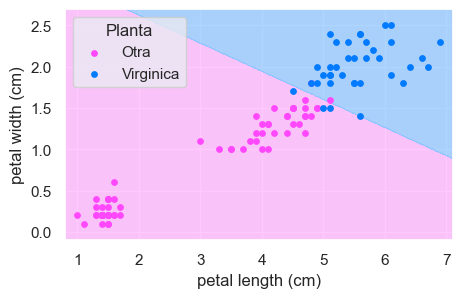

In [23]:
from matplotlib.colors import ListedColormap

colormap_frontier=('#ffb7fe', '#93c7ff')
colormap_points=('#ff48fd', '#007aff')

plt.figure(figsize=(5, 3))
plt.contourf(
    X1, X2, log_2_attr.predict(X_cont).reshape(X1.shape),
    alpha=0.75, cmap=ListedColormap(colormap_frontier)
)
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())

# Puntos de entrenamiento
lab = ["Otra", "Virginica"]
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(
        X_set[y_set == j, 0], X_set[y_set == j, 1],
        color=colormap_points[i], label=lab[i],
        s=15
    )

plt.xlabel(two_col[0]) 
plt.ylabel(two_col[1]) 
plt.legend(title="Planta")

plt.show()

De este gráfico entendemos por qué este modelo es considerado un clasificador lineal: la frontera de decisión (donde cambia el color del fondo) es una recta. Recuerden que la función **logit** es una combinación lineal de los atributos, lo cual se manifiesta aquí como una línea de separación (en espacios de `k` dimensiones, esa frontera es un hiperplano de dimensión `k-1`).

En el conjunto de entrenamiento, observamos que el modelo logra separar bastante bien las clases. Toda flor cuyo pétalo tenga dimensiones que caen en la zona azul será clasificada como `virginica`. A simple vista, el modelo clasificó mal a 4 `virginicas` y a una `no virginica`, ya que quedaron del lado incorrecto de la frontera.

¿Este modelo generaliza bien o no?
🎯 Paciencia, veamos un caso más.

### Regresión logística usando todos los atributos

Por último, aplicamos una regresión logística utilizando todos los atributos del dataset. Instanciamos el pipeline y entrenamos el modelo:

In [24]:
four_col = list(X_train.columns)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), four_col)
    ]
)

log_4_attr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LogisticRegression(random_state=0))
])

# Entrenamos el modelo
log_4_attr.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['sepal length (cm)',
                                                   'sepal width (cm)',
                                                   'petal length (cm)',
                                                   'petal width (cm)'])])),
                ('regressor', LogisticRegression(random_state=0))])

Este modelo aprovecha toda la información disponible. En pasos siguientes, vamos a evaluar su rendimiento, compararlo con los anteriores y visualizar las métricas.

---
## Métricas de evaluación

Bueno, dejemos de dar vueltas y veamos las métricas de evaluación de los tres modelos. Primero, obtengamos la predicción sobre el conjunto de evaluación:

In [25]:
y_pred_1 = log_1_attr.predict(X_test_one)
y_pred_2 = log_2_attr.predict(X_test_two)
y_pred_4 = log_4_attr.predict(X_test)

Ahora calculemos la matriz de confusión para cada uno de los modelos, utilizando [`confusion_matrix`](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#confusion-matrix) de scikit-learn:

In [26]:
from sklearn.metrics import confusion_matrix

cm_1_attr = confusion_matrix(y_test, y_pred_1)
cm_2_attr = confusion_matrix(y_test, y_pred_2)
cm_4_attr = confusion_matrix(y_test, y_pred_4)

cms = [cm_1_attr, cm_2_attr, cm_4_attr]
titles = ["Usando ancho de petalo", "Usando atributos del petalo", "Todos los atributos"]

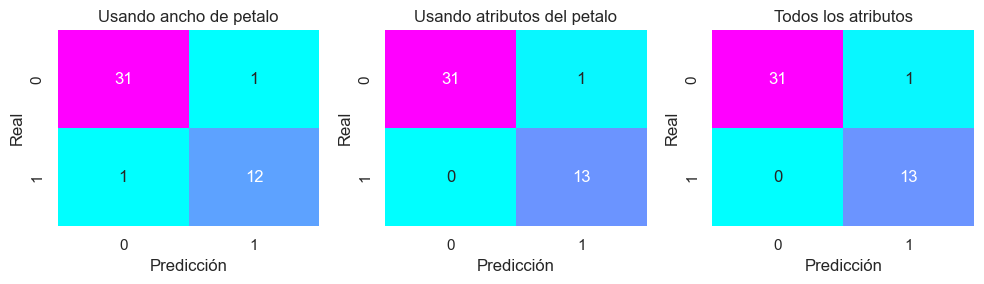

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

for ax, cm, title in zip(axes, cms, titles):
    sns.heatmap(cm, annot=True, fmt="d", cmap="cool", cbar=False, ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Predicción")
    ax.set_ylabel("Real")

plt.tight_layout()
plt.show()

A partir de las matrices de confusión, observamos que los tres modelos generalizan bastante bien:

- El modelo que usa solo el ancho del pétalo tiene un `falso positivo` y un `falso negativo`.
- El modelo que usa los dos atributos del pétalo comete solo un `falso positivo`, es decir, clasifica correctamente todas las plantas `virginica`.
- El modelo que utiliza todos los atributos tiene el mismo rendimiento que el anterior, lo que sugiere que agregar más atributos no mejora el desempeño respecto al modelo que solo usa los del pétalo.

Ahora veamos cómo esto se manifiesta en otras métricas: sensibilidad, especificidad y exactitud balanceada. Como **scikit-learn** no ofrece funciones directas para estas métricas, las calculamos a partir de la matriz de confusión.

In [28]:
def sens_spec(cm):
    sensitivity = cm[1, 1] / np.sum(cm[1, :])
    specifity = cm[0, 0] / np.sum(cm[0, :])
    balanced_accuracy = (sensitivity + specifity) / 2

    return sensitivity, specifity, balanced_accuracy

Calculamos para cada modelo:

In [29]:
sensitivity_1_attr, specifity_1_attr, balanced_accuracy_1_attr = sens_spec(cm_1_attr)
sensitivity_2_attr, specifity_2_attr, balanced_accuracy_2_attr = sens_spec(cm_2_attr)
sensitivity_4_attr, specifity_4_attr, balanced_accuracy_4_attr = sens_spec(cm_4_attr)

print(titles[0])
print(f"Sensibilidad: {sensitivity_1_attr}")
print(f"Especificidad: {specifity_1_attr}")
print(f"Exactitud balanceada: {balanced_accuracy_1_attr}\n")

print(titles[1])
print(f"Sensibilidad: {sensitivity_2_attr}")
print(f"Especificidad: {specifity_2_attr}")
print(f"Exactitud balanceada: {balanced_accuracy_2_attr}\n")

print(titles[2])
print(f"Sensibilidad: {sensitivity_4_attr}")
print(f"Especificidad: {specifity_4_attr}")
print(f"Exactitud balanceada: {balanced_accuracy_4_attr}")

Usando ancho de petalo
Sensibilidad: 0.9230769230769231
Especificidad: 0.96875
Exactitud balanceada: 0.9459134615384616

Usando atributos del petalo
Sensibilidad: 1.0
Especificidad: 0.96875
Exactitud balanceada: 0.984375

Todos los atributos
Sensibilidad: 1.0
Especificidad: 0.96875
Exactitud balanceada: 0.984375


Tal como veíamos en las matrices de confusión, la sensibilidad es 1 en los dos últimos modelos. A pesar de usar solo un atributo, el modelo que considera el ancho del pétalo tiene un rendimiento muy bueno, lo que confirma que es una variable con alta capacidad predictiva, como refleja su exactitud balanceada.

Si nos enfocamos en la clase positiva, podemos analizar la **precisión** y la **recuperación (recall)**. En este caso, sí podemos utilizar funciones de scikit-learn: [`precision_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html) y [`recall_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html).

In [30]:
from sklearn.metrics import precision_score, recall_score

In [31]:
print(titles[0])
print(f"Precision: {precision_score(y_test, y_pred_1)}")
print(f"Recuperación: {recall_score(y_test, y_pred_1)}\n")

print(titles[1])
print(f"Precision: {precision_score(y_test, y_pred_2)}")
print(f"Recuperación: {recall_score(y_test, y_pred_2)}\n")

print(titles[2])
print(f"Precision: {precision_score(y_test, y_pred_4)}")
print(f"Recuperación: {recall_score(y_test, y_pred_4)}")

Usando ancho de petalo
Precision: 0.9230769230769231
Recuperación: 0.9230769230769231

Usando atributos del petalo
Precision: 0.9285714285714286
Recuperación: 1.0

Todos los atributos
Precision: 0.9285714285714286
Recuperación: 1.0


Aquí queda claro que los tres modelos tienen la misma precisión. Es decir, agregar atributos no mejora la precisión, aunque sí mejora la recuperación, que se vuelve perfecta en los modelos con más atributos.

También podemos evaluar los modelos con las métricas **F1** y **Fβ**, que equilibran precisión y recuperación. Scikit-learn provee las funciones [`f1_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) y [`fbeta_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html):

In [32]:
from sklearn.metrics import f1_score, fbeta_score

print(titles[0])
print(f"F1-score: {f1_score(y_test, y_pred_1)}")
print(f"F2-score: {fbeta_score(y_test, y_pred_1, beta=2)}")
print(f"F0.5-score: {fbeta_score(y_test, y_pred_1, beta=0.5)}\n")

print(titles[1])
print(f"F1-score: {f1_score(y_test, y_pred_2)}")
print(f"F2-score: {fbeta_score(y_test, y_pred_2, beta=2)}")
print(f"F0.5-score: {fbeta_score(y_test, y_pred_2, beta=0.5)}\n")

print(titles[2])
print(f"F1-score: {f1_score(y_test, y_pred_4)}")
print(f"F2-score: {fbeta_score(y_test, y_pred_4, beta=2)}")
print(f"F0.5-score: {fbeta_score(y_test, y_pred_4, beta=0.5)}\n")

Usando ancho de petalo
F1-score: 0.9230769230769231
F2-score: 0.9230769230769231
F0.5-score: 0.9230769230769231

Usando atributos del petalo
F1-score: 0.9629629629629629
F2-score: 0.9848484848484849
F0.5-score: 0.9420289855072463

Todos los atributos
F1-score: 0.9629629629629629
F2-score: 0.9848484848484849
F0.5-score: 0.9420289855072463



Una función interesante es [`classification_report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html), que resume varias métricas en un solo reporte:

In [33]:
from sklearn.metrics import classification_report

In [34]:
target_names = ["No virginica", "Virginica"]

print(titles[0])
print(classification_report(y_test, y_pred_1, target_names=target_names))

Usando ancho de petalo
              precision    recall  f1-score   support

No virginica       0.97      0.97      0.97        32
   Virginica       0.92      0.92      0.92        13

    accuracy                           0.96        45
   macro avg       0.95      0.95      0.95        45
weighted avg       0.96      0.96      0.96        45



In [35]:
print(titles[1])
print(classification_report(y_test, y_pred_2, target_names=target_names))

Usando atributos del petalo
              precision    recall  f1-score   support

No virginica       1.00      0.97      0.98        32
   Virginica       0.93      1.00      0.96        13

    accuracy                           0.98        45
   macro avg       0.96      0.98      0.97        45
weighted avg       0.98      0.98      0.98        45



In [36]:
print(titles[2])
print(classification_report(y_test, y_pred_4, target_names=target_names))

Todos los atributos
              precision    recall  f1-score   support

No virginica       1.00      0.97      0.98        32
   Virginica       0.93      1.00      0.96        13

    accuracy                           0.98        45
   macro avg       0.96      0.98      0.97        45
weighted avg       0.98      0.98      0.98        45



### Curvas ROC

Como estamos usando modelos probabilísticos, podemos evaluarlos sin depender del umbral de decisión. Para ello, obtenemos la salida probabilística con `.predict_proba()`:

In [37]:
p_pred_1 = log_1_attr.predict_proba(X_test_one)
p_pred_2 = log_2_attr.predict_proba(X_test_two)
p_pred_4 = log_4_attr.predict_proba(X_test)

In [38]:
p_pred_1[:5, :]

array([[9.98039971e-01, 1.96002947e-03],
       [9.98769681e-01, 1.23031920e-03],
       [1.54955577e-01, 8.45044423e-01],
       [9.99227933e-01, 7.72066663e-04],
       [9.98769681e-01, 1.23031920e-03]])

El orden de las columnas en la salida es `[clase 0, clase 1]`, es decir, `[no virginica, virginica]`.

Con estas probabilidades, podemos construir la [curva ROC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) utilizando la probabilidad asignada a la clase positiva (`virginica`):

In [39]:
from sklearn.metrics import roc_curve

fpr_1_attr, tpr_1_attr, thr_1_attr = roc_curve(y_test, p_pred_1[:, 1])
fpr_2_attr, tpr_2_attr, thr_2_attr = roc_curve(y_test, p_pred_2[:, 1])
fpr_4_attr, tpr_4_attr, thr_4_attr = roc_curve(y_test, p_pred_4[:, 1])

Graficamos la curva ROC:

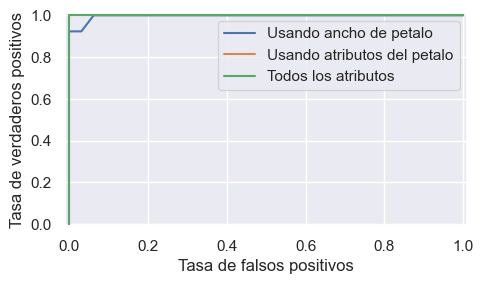

In [40]:
plt.figure(figsize=(5, 3))
plt.plot(fpr_1_attr, tpr_1_attr, label=titles[0])
plt.plot(fpr_2_attr, tpr_2_attr, label=titles[1])
plt.plot(fpr_4_attr, tpr_4_attr, label=titles[2])
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("Tasa de falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")
plt.legend()
plt.tight_layout();

Y si queremos, también podemos calcular directamente el área bajo la curva (AUC), usando [`roc_auc_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html):

In [41]:
from sklearn.metrics import roc_auc_score

print(titles[0])
print(f"AUC: {roc_auc_score(y_test, p_pred_1[:, 1])}\n")

print(titles[1])
print(f"AUC: {roc_auc_score(y_test, p_pred_2[:, 1])}\n")

print(titles[2])
print(f"AUC: {roc_auc_score(y_test, p_pred_4[:, 1])}")

Usando ancho de petalo
AUC: 0.9963942307692308

Usando atributos del petalo
AUC: 1.0

Todos los atributos
AUC: 1.0


Como era de esperar, los modelos que usan más atributos tienen AUC cercano a 1, es decir, son clasificadores casi perfectos. Esto también sugiere que si ajustamos el umbral de decisión (en lugar de usar 0.5), podríamos mejorar el rendimiento aún más. Sin embargo, no debemos ajustar el umbral usando el set de testeo, porque perderíamos la capacidad de evaluar generalización. Esto debería hacerse usando un **set de validación** o mediante **validación cruzada**.

--- 

## Regresión logística multiclase

En los videos vimos que la regresión logística puede generalizarse para realizar clasificaciones multiclase. En nuestro dataset, como contamos con tres tipos de plantas, podemos entrenar un modelo multiclase y analizar su desempeño. En este caso, para simplificar, utilizaremos los cuatro atributos disponibles. A nivel de scikit-learn, no es necesario realizar ninguna modificación especial: simplemente se utiliza la clase `LogisticRegression`, que se encargará automáticamente de configurar el modelo para clasificación multiclase al momento del entrenamiento.

Primero, separamos el dataset para el caso multiclase:

In [42]:
X = df_iris.drop(columns=["label", "label_binary"])
y = df_iris["label"]

y.value_counts()

label
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64

En este caso, tenemos la misma cantidad de observaciones para las tres clases, por lo que nos encontramos ante un **problema balanceado**.

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

Entrenamos el modelo:

In [44]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), four_col)
    ]
)

multi_class_log_4_attr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LogisticRegression(random_state=0))
])

multi_class_log_4_attr.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['sepal length (cm)',
                                                   'sepal width (cm)',
                                                   'petal length (cm)',
                                                   'petal width (cm)'])])),
                ('regressor', LogisticRegression(random_state=0))])

Ahora veamos una predicción del modelo:

In [45]:
multi_class_log_4_attr.predict(X_train.iloc[0:1, :])

array(['virginica'], dtype=object)

Como entrenamos el modelo utilizando clases con nombres, la salida será directamente la clase correspondiente.

> ⚠️ **Nota**: La implementación de scikit-learn se encarga automáticamente de evaluar las salidas de los modelos de regresión logística para cada clase, seleccionar la clase con mayor probabilidad y devolverla como predicción final.

También podemos observar la salida probabilística:

In [46]:
multi_class_log_4_attr.predict_proba(X_train.iloc[0:1, :])

array([[0.0014569 , 0.45372023, 0.54482287]])

Esto nos muestra la probabilidad de que esa observación pertenezca a cada clase. El orden de las clases se obtiene así:

In [47]:
multi_class_log_4_attr['regressor'].classes_

array(['setosa', 'versicolor', 'virginica'], dtype=object)

La predicción con `.predict()` selecciona simplemente la clase con mayor probabilidad:

In [48]:
# Obtenemos la salida probabilística
p_obs = multi_class_log_4_attr.predict_proba(X_train.iloc[0:1, :])

# Obtenemos la posición del valor máximo
pos_max = np.argmax(p_obs)

# Y obtenemos la clase correspondiente
print(multi_class_log_4_attr['regressor'].classes_[pos_max])

virginica


Veamos ahora cómo fue el desempeño del modelo utilizando métricas. Para eso usamos `classification_report()`:

In [49]:
y_pred = multi_class_log_4_attr.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        17
  versicolor       1.00      0.93      0.97        15
   virginica       0.93      1.00      0.96        13

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45



Podemos observar que el modelo identifica perfectamente a la clase `setosa`. Esto era esperable, ya que en el análisis exploratorio vimos que las características de esta planta son muy diferentes de las otras dos. En el caso de `versicolor` y `virginica`, las distribuciones estaban más solapadas, por lo que vemos una pequeña caída en el rendimiento. Sin embargo, en términos prácticos, el modelo generaliza muy bien.

> 🧠 Nota: Se podrían obtener más métricas, como también las curvas ROC. En este caso, se pueden generar tres curvas ROC, una para cada clase, utilizando el esquema de "una clase contra el resto".

---

### Fronteras en el caso multiclase

Para finalizar, veamos cómo se forman las fronteras de decisión en un caso multiclase. Entrenaremos un modelo utilizando solo dos atributos (los correspondientes al pétalo).

In [50]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), two_col)
    ]
)

multi_class_log_2_attr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LogisticRegression(random_state=0))
])

multi_class_log_2_attr.fit(X_train[two_col], y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['petal length (cm)',
                                                   'petal width (cm)'])])),
                ('regressor', LogisticRegression(random_state=0))])

Ahora visualizamos las fronteras:

In [51]:
# Creamos la malla de puntos para el gráfico
X_set, y_set = X_train_two.to_numpy(), y_train
X1, X2 = np.meshgrid(
    np.arange(start=X_set[:, 0].min() - 0.2, stop=X_set[:, 0].max() + 0.2, step=0.005),
    np.arange(start=X_set[:, 1].min() - 0.2, stop=X_set[:, 1].max() + 0.2, step=0.005)
)
X_cont = pd.DataFrame(np.array([X1.ravel(), X2.ravel()]).T, columns=two_col)

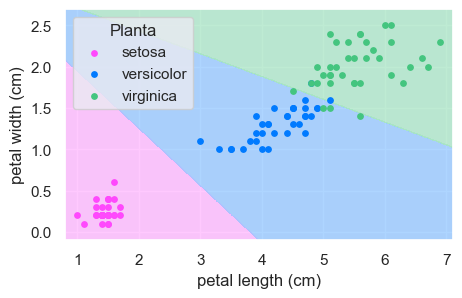

In [52]:
from matplotlib.colors import ListedColormap

colormap_frontier=('#ffb7fe', '#93c7ff', "#a9e5c5")
colormap_points=('#ff48fd', '#007aff', "#44c57f")

# Crear el gráfico de contorno
plt.figure(figsize=(5, 3))
plt.contourf(
    X1, X2, np.argmax(multi_class_log_2_attr.predict_proba(X_cont), axis=1).reshape(X1.shape),
    alpha=0.75, cmap=ListedColormap(colormap_frontier)
)
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())

# Graficar los puntos de entrenamiento
lab = ['setosa', 'versicolor', 'virginica']
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(
        X_set[y_set == j, 0], X_set[y_set == j, 1],
        color=colormap_points[i], label=lab[i],
        s=15
    )

plt.xlabel(two_col[0]) 
plt.ylabel(two_col[1]) 
plt.legend(title="Planta")

plt.show()

En el gráfico, podemos ver cómo se forman las fronteras de clasificación para el caso multiclase. Aunque seguimos utilizando regresión logística (un modelo lineal), las fronteras no son una sola línea, sino múltiples líneas rectas que dividen el espacio en regiones. Cada región está asociada a una clase distinta, y la predicción del modelo para un nuevo punto dependerá de la región en la que caiga.

Por ejemplo, todas las zonas coloreadas en azul corresponden a la clase `versicolor`. Esto significa que, para cualquier punto del espacio de atributos que caiga en esa región, el modelo predecirá que pertenece a esa clase.

Estas fronteras son el resultado de aplicar la estrategia **"uno contra todos"**: el modelo entrena una regresión logística por clase, y luego selecciona la clase con la mayor probabilidad estimada.